# Text Similarity

<!--<badge>--><a href="https://colab.research.google.com/github/TheAIDojo/Machine_Learning_Bootcamp/blob/main/Week 08 - Sequence Modeling Applications/3- Text_Similarity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a><!--</badge>-->

Text similarity has to determine how 'close' two pieces of text are both in surface closeness `lexical similarity` and meaning `semantic similarity`.

One of the essential techniques of NLP which is being used to find the closeness between two chunks of text by it's meaning or by surface. 

# Download the Dataset

In [ ]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

## Quora Question Pairs
The goal of this dataset is to predict which of the provided pairs of questions contain two questions with the same meaning. The ground truth is the set of labels that have been supplied by human experts. The ground truth labels are inherently subjective, as the true meaning of sentences can never be known with certainty. Human labeling is also a 'noisy' process, and reasonable people will disagree. As a result, the ground truth labels on this dataset should be taken to be 'informed' but not 100% accurate, and may include incorrect labeling. We believe the labels, on the whole, to represent a reasonable consensus, but this may often not be true on a case by case basis for individual items in the dataset.

In [ ]:
!kaggle competitions download -c quora-question-pairs

 43% 9.00M/21.2M [00:12<00:12, 1.05MB/s]
100% 21.2M/21.2M [00:12<00:00, 1.80MB/s]
 93% 161M/173M [00:04<00:00, 45.0MB/s]
100% 173M/173M [00:04<00:00, 43.6MB/s]
100% 4.95M/4.95M [00:00<00:00, 24.4MB/s]

test.csv.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip /content/train.csv.zip

Archive:  /content/train.csv.zip
  inflating: train.csv               


# Import the Required Libraries

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn import model_selection, metrics
import seaborn as sn
import re

# Read and Preprocessing the Data

## Read data with pandas as Dataframe

In [ ]:
# read the csv file using the pandas as DataFrame
data_df = pd.read_csv("/content/train.csv")
# show the data
data_df

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0
...,...,...,...,...,...,...
404285,404285,433578,379845,How many keywords are there in the Racket prog...,How many keywords are there in PERL Programmin...,0
404286,404286,18840,155606,Do you believe there is life after death?,Is it true that there is life after death?,1
404287,404287,537928,537929,What is one coin?,What's this coin?,0
404288,404288,537930,537931,What is the approx annual cost of living while...,I am having little hairfall problem but I want...,0


In [ ]:
# drop the columns that are not required
data_df.drop(labels=["id", "qid1", "qid2"], axis=1, inplace=True)

In [ ]:
# show the data information
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   question1     404289 non-null  object
 1   question2     404288 non-null  object
 2   is_duplicate  404290 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 9.3+ MB


In [ ]:
# drop the rows that are having null values
data_df.dropna(inplace=True)

In [ ]:
# show the data information
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 404287 entries, 0 to 404289
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   question1     404287 non-null  object
 1   question2     404287 non-null  object
 2   is_duplicate  404287 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 12.3+ MB


## Cleaning the Text

In [ ]:
# create the clean data function
def clean_text(text):
    """Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers."""
    text = text.lower()
    text = re.sub("\[.*?\]", "", text)
    text = re.sub("https?://\S+|www\.\S+", "", text)
    text = re.sub("<.*?>+", "", text)
    text = re.sub("\n", "", text)
    text = re.sub(r"[^\w]", " ", text)
    text = re.sub("\w*\d\w*", "", text)
    text = " ".join(filter(lambda x: x[0] != "@", text.split()))
    return text


# clean the question1 and question2 column
data_df.question1 = data_df.question1.map(clean_text)
data_df.question2 = data_df.question2.map(clean_text)

In [ ]:
# show the data
data_df

,question1,question2,is_duplicate
0,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0
1,what is the story of kohinoor koh i noor diamond,what would happen if the indian government sto...,0
2,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0
3,why am i mentally very lonely how can i solve it,find the remainder when is divided by,0
4,which one dissolve in water quikly sugar salt ...,which fish would survive in salt water,0
...,...,...,...
404285,how many keywords are there in the racket prog...,how many keywords are there in perl programmin...,0
404286,do you believe there is life after death,is it true that there is life after death,1
404287,what is one coin,what s this coin,0
404288,what is the approx annual cost of living while...,i am having little hairfall problem but i want...,0


## Balancing the Data

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc2a8bb6a10>]],
      dtype=object)

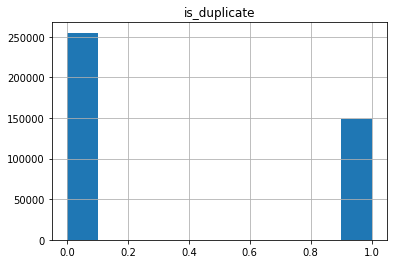

In [ ]:
# plot the data histogram
data_df.hist()

In [ ]:
#  make sure the class zero and class one are balanced
data_df = pd.concat(
    [
        data_df[(data_df.is_duplicate == 1)],
        data_df[(data_df.is_duplicate == 0)].iloc[:149263],
    ]
)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc2ae8cd990>]],
      dtype=object)

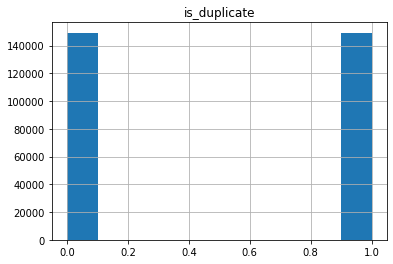

In [ ]:
# plot the data histogram
data_df.hist()

## Split the Data to Train and Test

In [ ]:
train, test = model_selection.train_test_split(
    data_df, test_size=0.1, stratify=data_df.is_duplicate
)

In [ ]:
train

,question1,question2,is_duplicate
52481,how should you train a labrador beagle mix,how do you train a dog,0
40375,my hair are very straight and they go over my ...,i have straight hair which i don t like at all...,0
197389,what is a tmt steel rod and what is the differ...,what is the difference between and tmt bars,0
84309,iep in thapar university,i read alot of topics about geniuses haveing a...,0
142544,what is the meaning of investments by owners,what do you mean by investment,0
...,...,...,...
51592,what are some tips on making it through the jo...,what are some tips on making it through the jo...,0
167097,how can you get rid of infected pimples,how can i get rid of my acne,0
212729,what are the differences between irony and satire,what is the difference between irony and sarcasm,0
235253,what is it like to be drafted into the army,what is it like to be drafted into the military,1


## Preprocessing the Data 


In [ ]:
# create the tokenizer and fit it of the question1 column
voc_size = 10000
tokenizer = tf.keras.preprocessing.text.Tokenizer(
    num_words=voc_size,
    oov_token="<OOV>",
    filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n<>',
)  # remove  < and >  from the filter list
# fit the tokenizer on the texts
tokenizer.fit_on_texts(data_df.question1)

In [ ]:
# create function to convert text to sequence of word-indexes
def tokenize(tokenizer, text):
    # tokenize the texts and create a seqence
    tensor = tokenizer.texts_to_sequences(text)
    # pad the sequences
    tensor = tf.keras.preprocessing.sequence.pad_sequences(
        tensor, maxlen=200, padding="post", truncating="post"
    )
    # return the tokenizer and the sequence

    return tensor

In [ ]:
# convert the question1 and question2 column in train and test to sequence of word-indexes using the tokenize function
train_question1_tensor = tokenize(tokenizer, train.question1)
train_question2_tensor = tokenize(tokenizer, train.question2)
# get the labels for the train data
y_train = train.is_duplicate

test_question1_tensor = tokenize(tokenizer, test.question1)
test_question2_tensor = tokenize(tokenizer, test.question2)
# get the labels for the test data
y_test = test.is_duplicate

# Dataset pipeline

In [ ]:
# create function to create the data pipeline
def dataset_creater(x1, x2, y):
    data = tf.data.Dataset.from_tensor_slices(((x1, x2), y))
    data = data.shuffle(1028)  # shuffle the data
    data = data.batch(32)  # make batch
    data = data.prefetch(tf.data.AUTOTUNE)
    return data


# create the data pipeline for training and testing
train_dataset = dataset_creater(train_question1_tensor, train_question2_tensor, y_train)
test_dataset = dataset_creater(test_question1_tensor, test_question2_tensor, y_test)

In [ ]:
# get the first batch of the train dataset
for x, y in train_dataset.take(1):
    pass

# Modeling

**Siamese Neural Network**

A Siamese Network is a type of network architecture that contains two or more identical subnetworks used to generate feature vectors for each input and compare them.

Siamese Networks can be applied to different use cases, like detecting duplicates, finding anomalies, and face recognition.

This example uses a Siamese Network with two identical subnetworks. We will provide two text to the model, where first  of them will be similar (anchor and positive samples), and the second will be unrelated (anchor and negative.) Our goal is for the model to learn to estimate the similarity between the meaning of the text.

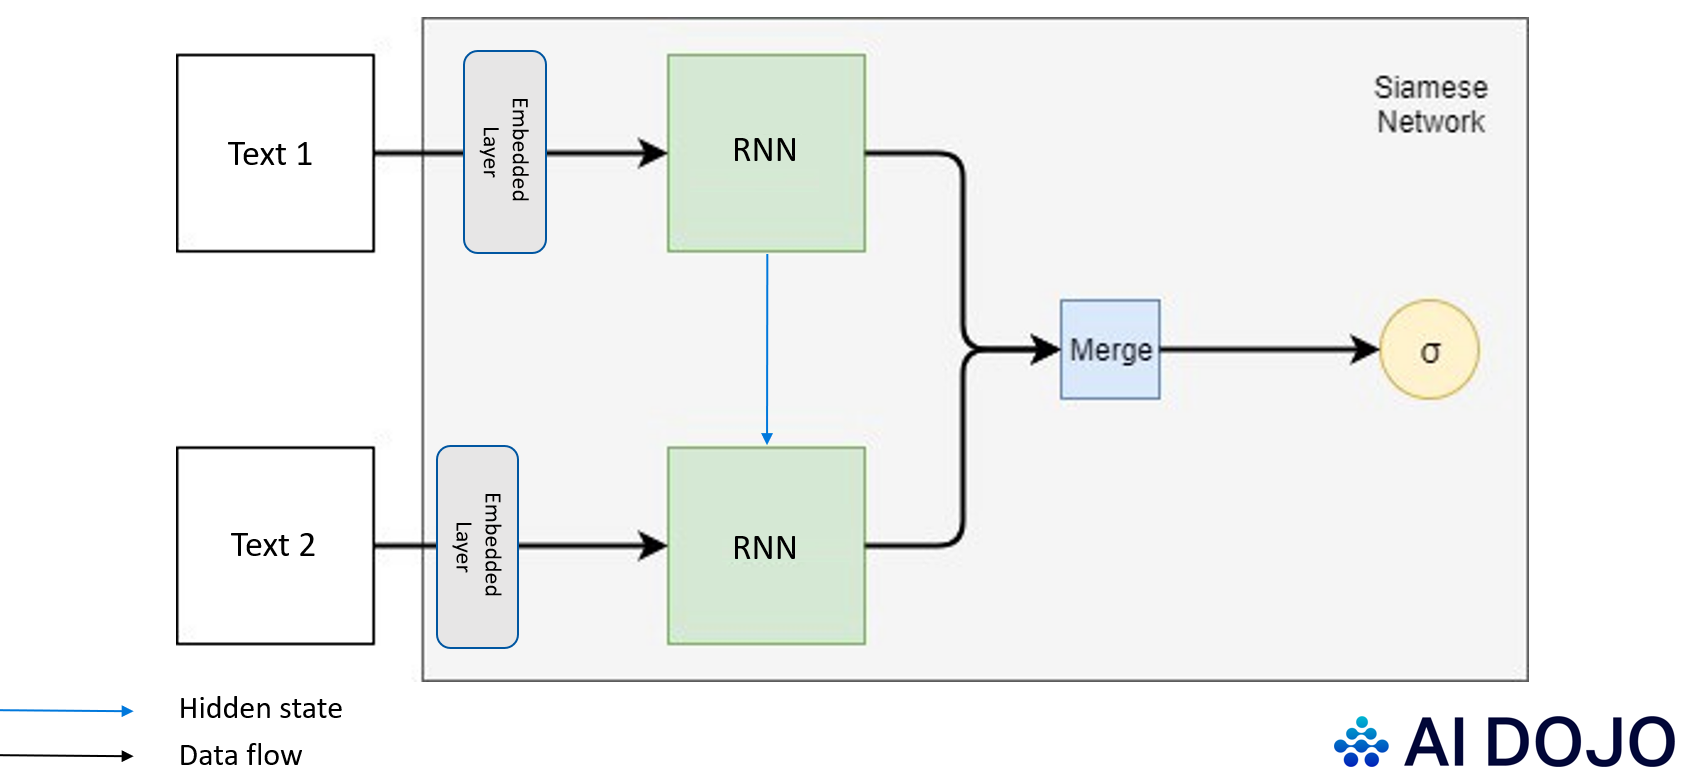

## Create the Model



In [12]:
class ModelBiGRU(tf.keras.Model):
    def __init__(self):
        super(ModelBiGRU, self).__init__()

        # create the Embedding layer with the embedding dimension of 128
        self.emb = tf.keras.layers.Embedding(
            input_dim=voc_size + 1, output_dim=128, mask_zero=True
        )
        # create the Bidirectional GRU layer with the hidden units of 64 and return state of the GRU layer
        self.gru = tf.keras.layers.Bidirectional(
            tf.keras.layers.GRU(units=64, return_sequences=False, return_state=True)
        )
        # create the dense layer with the output units of 256
        self.d1 = tf.keras.layers.Dense(
            256,
            activation=tf.nn.leaky_relu,
            kernel_initializer=tf.initializers.he_uniform(),
        )
        # crate the drop out layer with the rate of 0.3
        self.dropout = tf.keras.layers.Dropout(0.3)
        # create the dense layer with the output units of 1
        self.out = tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)

    def call(self, inputs):
        # get the first element of the tuple == x1
        x1 = inputs[0]
        # get the second element of the tuple == x2
        x2 = inputs[1]

        # get the embedding of the x1
        x1 = self.emb(x1)
        # get the embedding of the x2
        # not we will use the same embedding layer as the x1
        x2 = self.emb(x2)
        # get the output of the GRU layer for the x1 with the hidden states for the BiGRU layer
        x1, hidden_1, hidden_2 = self.gru(x1)
        # use the same GRU layer for the x2 and make sure to use the same hidden states from the previous step
        x2, _, _ = self.gru(x2, [hidden_1, hidden_2])
        # concatenate the output of the GRU layer for the x1 and the output of the GRU layer for the x2
        x = tf.keras.layers.concatenate([x1, x2])
        # get the output of the dense layer
        x = self.d1(x)
        # get the output of the drop out layer
        x = self.dropout(x)
        # get the output of the dense layer
        x = self.out(x)
        # return the output of the dense layer
        return x

    def bulid_model(self):

        x = tf.keras.layers.Input(shape=(300,))

        return tf.keras.Model(inputs=x, outputs=self.call((x, x)))

In [13]:
# create the model
model = ModelBiGRU()

In [14]:
model.bulid_model().summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 embedding_3 (Embedding)        (None, 300, 128)     1280128     ['input_5[0][0]',                
                                                                  'input_5[0][0]']                
                                                                                                  
 bidirectional_3 (Bidirectional  [(None, 128),       74496       ['embedding_3[0][0]',            
 )                               (None, 64),                      'embedding_3[1][0]',            
                                 (None, 64)]                      'bidirectional_3[0][1]',  

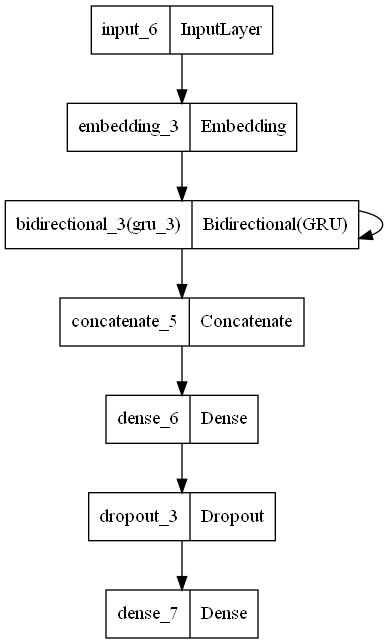

In [15]:
tf.keras.utils.plot_model(model.bulid_model())

In [ ]:
# create the loss function
loss_object = tf.keras.losses.BinaryCrossentropy()
# create the optimizer
optimizer = tf.keras.optimizers.Adam()

In [ ]:
# compile the model
model.compile(optimizer=optimizer, loss=loss_object, metrics=["acc"])

In [ ]:
# train the model on the dataset for 5 epochs
model.fit(train_dataset, epochs=5, validation_data=test_dataset)

Epoch 1/5
8397/8397 [==============================] - 408s 48ms/step - loss: 0.5024 - acc: 0.7524 - val_loss: 0.4512 - val_acc: 0.7868
Epoch 2/5
8397/8397 [==============================] - 402s 48ms/step - loss: 0.4092 - acc: 0.8125 - val_loss: 0.4338 - val_acc: 0.7972
Epoch 3/5
8397/8397 [==============================] - 401s 48ms/step - loss: 0.3410 - acc: 0.8522 - val_loss: 0.4496 - val_acc: 0.7974
Epoch 4/5
8397/8397 [==============================] - 401s 48ms/step - loss: 0.2835 - acc: 0.8823 - val_loss: 0.4897 - val_acc: 0.7965
Epoch 5/5
8397/8397 [==============================] - 401s 48ms/step - loss: 0.2352 - acc: 0.9050 - val_loss: 0.5508 - val_acc: 0.8002


## Model Evaluation

In [ ]:
# make predictions on the test data
pred = model((test_question1_tensor, test_question2_tensor))
pred_list = []
# convert the predictions to binary
for i in pred.numpy():
    if i > 0.7:
        pred_list.append(1)

    else:

        pred_list.append(0)
pred_array = np.array(pred_list)

In [ ]:
# calculate the predictions and recall
precision = tf.metrics.Precision(0.5)
recall = tf.metrics.Recall(0.5)
# calculate the confusion matrix
confusion_matrix = metrics.confusion_matrix(y_test, pred_array, labels=[0, 1])
print(
    f"binary  loss : {tf.reduce_mean(tf.metrics.binary_crossentropy(y_test.reshape(-1,1),pred))}"
)
print(
    f"biary acc : {tf.reduce_mean(tf.metrics.binary_accuracy(y_test.reshape(-1,1),pred))}"
)
print(f"precision:{precision(y_test.reshape(-1,1),pred)}")
print(f"recall : {recall(y_test.reshape(-1,1),pred)}")
sn.heatmap(confusion_matrix, cmap="Blues", annot=True, linewidths=0.9)